<a href="https://colab.research.google.com/github/samanehPahlavani/MscFraudDetection/blob/main/Model3_ML(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
try:
  import google.colab
  !{sys.executable} -m pip -q -q install pandas>=0.24.2
  !{sys.executable} -m pip -q -q install matplotlib>=3.0.3
  !{sys.executable} -m pip -q -q install seaborn>=0.9.1
  !{sys.executable} -m pip -q -q install numpy>=1.18.5
  !{sys.executable} -m pip -q -q install scikit-learn>=0.22.2
  !{sys.executable} -m pip -q -q install pycm>=2.2
except:
  pass


In [20]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare
from sklearn.preprocessing import StandardScaler


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
def LoadData():
  warnings.filterwarnings('ignore')
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  df = pd.read_csv(os.path.join("/content/drive/MyDrive/EtherFirstDataSet/", "3.csv"))
  return df

In [26]:
RANDOM_STATE = 23

def preprocess(df):
  positive_sample = df[df["Flag"] == 1]
  negative_sample = df[df["Flag"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
  data = pd.concat([negative_sample, positive_sample], axis = 0)
  y = data["Flag"]
  X = data.iloc[:,2:]

  for col in X.columns:
      X[col] = X[col].fillna(X[col].mean())
  return X,y


In [40]:
df=LoadData()
X,y=preprocess(df)

### **Neural Network**

In [32]:
from sklearn.neural_network import MLPClassifier
FOLD_NUMBER = 20
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]



A multilayer perceptron (MLP) is a fully connected class of feedforward artificial neural network (ANN). An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.


**Parameters:**

In [48]:
nn_params = {"hidden_layer_sizes": (120, 120), "solver": "adam"}


Train

We will use 10-Folds cross-validator. Split dataset into 10 consecutive folds.

Each fold is then used once as a validation while the 9 remaining folds form the training set.


**Train**

In [49]:
nn_model = MLPClassifier(**nn_params)
nn_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
nn_cm_worst = None
nn_cm_best = None
nn_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    nn_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = nn_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    nn_cm_list.append(cm)
    if nn_cm_worst is None:
        nn_cm_worst = cm
    else:
        if cm.Overall_ACC < nn_cm_worst.Overall_ACC:
            nn_cm_worst = cm

    if nn_cm_best is None:
        nn_cm_best = cm
    else:
        if cm.Overall_ACC > nn_cm_best.Overall_ACC:
            nn_cm_best = cm

**Performance**

Model Name: Neural Network Classifier
10-Fold Metrics: 

Accuracy : 0.82

F1 : 0.83

Kappa : 0.65

Precision : 0.8

Recall : 0.88



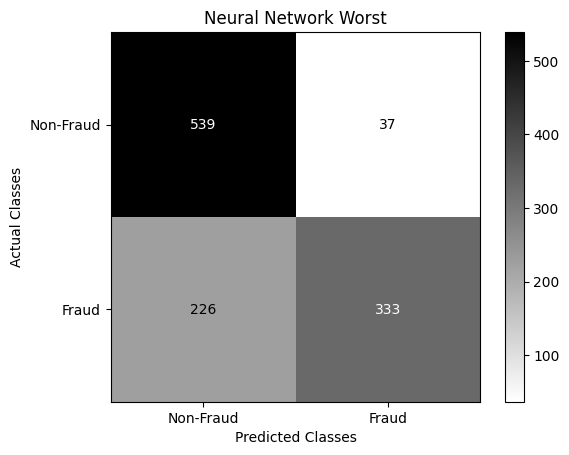

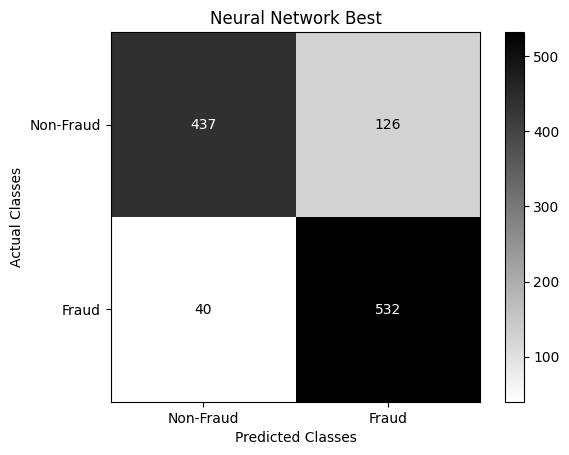

In [50]:
print("Model Name: Neural Network Classifier")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
nn_cm_worst.plot(title="Neural Network Worst", number_label=True)
nn_cm_best.plot(title="Neural Network Best", number_label=True)
plt.show()